# Webscraping required skills for chosen programming field 
#### (data scientist in this case)
websites used: https://www.reed.co.uk/, https://indeed.com/, https://www.pracuj.pl/ <br>
python tools used: selenium, BeautifulSoup, requests, pandas, mysql connector, matplotlib

### required imports

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import requests
import pandas as pd
import time
import random

Job posting websites often use dynamic HTML generated by JavaScript, making it difficult to extract the content using traditional methods. To accurately retrieve the HTML code displayed on the page, we must use Selenium <br>
    <b>in this project I will use Google Chrome so I need Chrome driver to work with Selenium <b>

In [2]:
PATH = "C:\Program Files (x86)\chromedriver.exe"
s = Service(PATH)

<b>Three different scrapers are needed for each website because link structures, html elements 
and tools for scraping given website (requests, selenium) are not the same,
 so uniersal function can't be used here.</b>

### Webscraping indeed.com

In [3]:
def scrape_indeed(field,pages="all"):
    # A list to store the job descriptions obtained from Indeed
    indeed_data = []
    # Generate the base URL for searching the desired job field on Indeed
    base_link = "https://indeed.com/jobs?q=" + '+'.join(field.split()) +"&start="
    
    
    page_nr_prefix = 0
    
    should_continue = True
    # Start the web driver
    with webdriver.Chrome(service=s) as driver:
        while should_continue:
            # Load the job search results page
            driver.get(base_link + str(page_nr_prefix) + "0")
            # Get the HTML content of the page
            html_content = driver.page_source
            
            bs = BeautifulSoup(html_content, "lxml")
            # Find all job titles on the page
            jobs_list = bs.find("ul", class_="jobsearch-ResultsList").find_all("a", class_="jcs-JobTitle")
            
            # Iterate over each job title
            for a_tag in jobs_list:
                #Check if job title exists
                if a_tag:
                    # Generate the URL for the job post
                    job_post_url = "https://www.indeed.com/viewjob?" + a_tag["href"].split("?")[1]
                    # Wait for a random amount of time to avoid being detected as a scraper
                    time.sleep(random.randint(2, 5))
                    
                    # Load the job post
                    driver.get(job_post_url)
                    # Get the HTML content of the job post
                    job_html = driver.page_source
                    
                    job_bs = BeautifulSoup(job_html, "lxml")
                    # Find the job description on the job post
                    job_description = job_bs.find('div', class_="jobsearch-jobDescriptionText")
                    #Check if job description was found
                    if job_description:
                        # Add the job description to the list of job descriptions
                        indeed_data.append(job_description.text)     
                        
            #End scraping on chosen page if "page" argument was given
            if pages != "all":
                if pages == page_nr_prefix+1:
                    should_continue = False            
            
            # Find the navigation bar for pagination
            nav = bs.find("nav", attrs={"role":"navigation", "aria-label":"pagination", "class":"css-jbuxu0 ecydgvn0"})
            # If the navigation bar does not exist or does not have any divs, stop scraping
            if not nav or not nav.find_all("div"):
                should_continue = False
            else:    
                # Increment the page counter
                page_nr_prefix += 1
                
                    
    # Return the list of job descriptions
    return indeed_data


In [4]:
indeed_data = scrape_indeed("data scientist",1)

In [5]:
#sample of scraped data 
indeed_data[0][:300]

'\n\n\n\n\n\n\n\n\nGeneral information \n\n\n\n\nAll posting locations: Remote, Illinois, United States of America \nJob Function: 16 - Digital \nDate Published: 10-Feb-2023 \nRef #: R-66526 \nBase Salary Range: $83,400.00 - $104,200.00 \nTarget Total Cash Range: $104,250.00 - $130,250.00 \nTarget Total Cash: Target tot'

### Websraping pracuj.pl

The requests library will be used for this scenario as the majority of elements on the website are constructed with static HTML

In [6]:
def scrape_pracuj(field,pages="all"):
    # Define base link for the job listings for a specific programming field
    base_link = "https://www.pracuj.pl/praca/"
    link = base_link + "%20".join(field.split()) + ";kw?pn="
    
    # Initialize the data list to store the results
    pracuj_data = []

    # Initialize page number to 1
    page = 1
    
    # Initialize the flag to continue scraping until the last page is reached
    should_continue = True
    
    # Use webdriver context manager to open the web page in a headless browser
    with webdriver.Chrome(service=s, options=webdriver.ChromeOptions().add_argument('--headless')) as driver:
        while should_continue:
            # Open the job listing page for the given page number
            driver.get(link + str(page))
            
            # Extract the entire page source
            html_content = driver.page_source
            
            # Create a BeautifulSoup object to parse the HTML content
            bs = BeautifulSoup(html_content, "lxml")
            
            # Find all the job posts on the current page
            job_list = bs.find_all("h2", attrs={"data-test":"offer-title"})
            
            for job in job_list:
                # Find the link to the job post
                a_tag = job.find("a")
                
                # Check if the link was found
                if a_tag:
                    job_post_url = a_tag["href"]
                    
                    # Add a delay between requests to avoid overloading the website's server
                    time.sleep(random.randint(5, 20))
                    
                    # Send a GET request to the job post URL
                    r = requests.get(job_post_url)
                    
                    if r.status_code == 200:
                        bspage = BeautifulSoup(r.text, "lxml")
                        skills = bspage.find("div", attrs={"data-scroll-id":"technologies-1"})
                        
                        # Check if the skills section exists
                        if skills:
                            # Check if the required skills section exists
                            if skills.find("div", attrs={"data-test":"section-technologies-expected"}):
                                required_skills = skills.find("div", attrs={"data-test":"section-technologies-expected"}).find_all("li")
                                for skill in required_skills:
                                    pracuj_data.append(skill.text)
                            
                            # Check if the optional skills section exists
                            if skills.find("div", attrs={"data-test":"section-technologies-optional"}):
                                optional_skills = skills.find("div", attrs={"data-test":"section-technologies-optional"}).find_all("li")
                                for skill in optional_skills:
                                    pracuj_data.append(skill.text)
                                    
                                    
            #End scraping on chosen page if "page" argument was given
            if pages != "all":
                if pages == page:
                    should_continue = False                      
                                    
            #Verify if the last button is "Następna"("next" in english). If not, 
            #it indicates that we have reached the final page
            try:
                nav = bs.find("div",class_="w1h4nogz").find_all("button")
                if nav[-1].text != "Następna":
                    should_continue = False
            except Exception:

                    should_continue = False                  
                                    
    return pracuj_data

        




In [7]:
pracuj_data = scrape_pracuj("data scientist")

In [9]:
#sample of scraped data
pracuj_data[0:9]

['Amazon Redshift',
 'Azure Synapse',
 'Snowflake Data Cloud',
 'Google BigQuery',
 'SQL',
 'Apache Airflow',
 'Python',
 'Docker',
 'Kubernetes']

### Webscraping reed.co.uk

Here we can use only requests

In [10]:
def scrape_reed(field,pages="all"):
    # Constructing the URL for the job listings for a specific programming field
    base_link = "https://www.reed.co.uk/jobs/"
    link = base_link + "-".join(field.split()) + "-jobs?pageno="
    
    # Initializing page counter
    page = 1

    # Initializing an empty list to store the scraped job descriptions
    reed_data = []
    
    # A flag variable to control the while loop
    should_continue = True
    
    # Iterating through all the pages of job listings
    while should_continue:
        # Getting the entire HTML content of the current page
        r = requests.get(link + str(page)).text

        # Parsing the HTML content using BeautifulSoup
        bs = BeautifulSoup(r, "lxml")
        
        # Finding all individual job listings on the current page
        job_list = bs.find_all("h2", class_="job-result-heading__title")
        
        # Iterating through each job listing
        for job in job_list:
            # Finding the link to the job description
            a_tag = job.find("a")
            
            # Checking if the job link was found
            if a_tag:
                job_post_url = a_tag["href"]
                
                # Implementing a delay to prevent overloading the website's server
                time.sleep(random.randint(5, 20))
                
                # Getting the HTML content of the job description page
                post_page = requests.get("https://www.reed.co.uk/" + job_post_url).text
                
                # Parsing the HTML content of the job description page
                bsp = BeautifulSoup(post_page, "lxml")
                
                # Finding and retrieving the job description text
                job_description = bsp.find("span", attrs={"itemprop":"description"})
                
                reed_data.append(job_description.text)
                
        #End scraping on chosen page if "page" argument was given
        if pages != "all":
            if pages == page_nr_prefix+1:
                should_continue = False          
        
        # Checking if the current page is the last page
        try:
            nav = bs.find("div", class_="page-counter").text.strip().split()
        except Exception:
            # If the page counter is not found, set `should_continue` to False
            should_continue = False
        else:    
            # If the page counter is found, compare the current page number with the last page number
            if nav[2] == nav[4]:
                # If the current page number is equal to the last page number, set `should_continue` to False
                should_continue = False
            page += 1
    
    return reed_data

In [11]:
reed_data = scrape_reed("data scientist")

In [13]:
#sample of scraped data
reed_data[0][0:300]

' We are looking for a Data Scientist, with experience in the UK general insurance markets in either commercial or personal lines, to join Willis Towers Watson in our Data Science team which is part of our consulting practice to help us develop our Data Science  advisory capability. You will work bes'

# Data wrangling

The collected job descriptions data must be structured and cleaned. However, before doing so, we need to extract the required skills, as these are often not clearly stated in the job posts from sources like Indeed and Reed, but instead presented as blocks of text. We can use <b>"pracuj_data"</b> for it, it already contains extracted skills, which for sure are all unique skills for data science you could think of, now we just need to use them to check if Reed and Indeed job descriptions contain any of these skills.

### First let's explore and transform pracuj_data

In [14]:
from collections import Counter
pd.set_option('display.max_rows', 150)

In [15]:
"""We use the Counter method to count the occurrences of unique values in the pracuj_data and convert every skill name to 
lowercase, making it easier to work with the data without worrying about case sensitivity."""
counted_values_pracuj = Counter([skill.lower() for skill in pracuj_data])
str(counted_values_pracuj)[0:43]

"Counter({'sql': 69, 'python': 60, 'git': 19"

In [16]:
#Transfrom Counter object to pandas DataFrame
df_pracuj = pd.DataFrame.from_dict(counted_values_pracuj, orient='index').reset_index().rename(columns={"index":"skill",0:"count"})

In [17]:
#Let's explore data for similar words, synonyms etc. and apply data cleaning and normalization
df_pracuj.sort_values(by="skill",ascending=False)

,skill,count
97,xml,1
79,visual basic,1
51,vba,3
9,terraform,4
37,tensorflow,5
109,tealeaf,1
94,tableau software,1
34,tableau,4
129,t-sql,2
80,sql managment studio,1


In [18]:
#It is convenient to set the index as programming language names.
df_pracuj.set_index("skill",inplace=True)

In [19]:
#We treat "tableau software" and "tableau" as same skill
df_pracuj.loc["tableau"] = df_pracuj.loc["tableau"]+df_pracuj.loc["tableau software"]

In [20]:
#There is "scala or java" skill, it will be delated,"scala" count and "java" count will be incremented by "scala or java" count
df_pracuj.loc[["scala","java"]] += df_pracuj.loc["scala or java"]

In [21]:
#We treat "powershell scripting" and "powershell" as same skill
df_pracuj.loc["powershell"] = df_pracuj.loc["powershell"]+df_pracuj.loc["powershell scripting"]

In [22]:
#We treat "powerquery"  and "power query " as same skill
df_pracuj.loc["powerquery"] = df_pracuj.loc["powerquery"]+df_pracuj.loc["power query"]

In [23]:
#There is "power bi/tableau" skill, it will be delated,"power bi" count and "tableau" 
#count will be incremented by "power bi/tableau" count
df_pracuj.loc[["power bi","tableau"]] += df_pracuj.loc["power bi/tableau"]

In [24]:
#We treat "power bi"  and "powerbi"  as same skill
df_pracuj.loc["power bi"] += df_pracuj.loc["powerbi"]

In [25]:
#We treat "power bi"  and "microsoft power bi"  as same skill
df_pracuj.loc["power bi"] += df_pracuj.loc["microsoft power bi"]

In [26]:
#We treat "java"  and "java 11+"  as same skill
df_pracuj.loc["java"] += df_pracuj.loc["java 11+"]

In [27]:
#Changing skill named "englsih" to "english language"
df_pracuj.rename(index={"english":"english language"},inplace=True)

In [28]:
#There is "bitbucket/gitlab" skill, there is also skill "gitlab" itself but there is no skill "bitbucket" so "gitlab" count
#will be incremented and "bitbutcket" skill will be created with "bitbucket/gitlab" count
df_pracuj.loc["gitlab"] += df_pracuj.loc["bitbucket/gitlab"]
df_pracuj.loc["bitbucket"] = df_pracuj.loc["bitbucket/gitlab"]

In [29]:
#We treat "redshift"  and "amazon redshift"  as same skill
df_pracuj.loc["redshift"] += df_pracuj.loc["amazon redshift"]

In [30]:
#We treat "ms excel"  and "microsoft excel"  as "excel"
df_pracuj.loc["excel"] = df_pracuj.loc["ms excel"] + df_pracuj.loc["microsoft excel"]

In [31]:
#We treat "machine learning"  and "ml/ai"  as same skill
df_pracuj.loc["machine learning"] = df_pracuj.loc["machine learning"] + df_pracuj.loc["ml/ai"]

In [32]:
#One of skills is called "microsoftâs bi stack" I guess this is "microsoft bi stack"
df_pracuj.rename(index={"microsoftâs bi stack":"microsoft bi stack"},inplace=True)

In [33]:
#Delete all skills names previously considered duplicate
df_pracuj.drop(index=["amazon redshift","bitbucket/gitlab","java 11+","microsoft power bi","powerbi","power bi/tableau",
                     "power query",
                      "powershell scripting","scala or java","tableau software",
                      "ms excel","microsoft excel","ml/ai"],inplace=True)

In [34]:
#Some skills are long desciprions or just not meaningful, these also must be delated
df_pracuj.drop(index=["polish","frequent pattern mining, statystyka bayesowska, anomaly detection, pattern recognition",
                     'build tools such as sbt or gradle',"hadoop and hdfs unit testing with scala test or similar"],inplace=True)

In [35]:
df_pracuj.sort_values(by="count",ascending=False).head()

,count
skill,
sql,69
python,60
git,19
power bi,16
docker,14


#### Now we can use unique skills from df_pracuj dataframe to search and count required skills from Indeed and Reed data sets.

<p style="color:red;font-size:1.5rem;">However, there is a major concern. The df_pracuj dataframe includes skills named "c" for C programming language and "r" for R programming language. This poses a problem when iterating through job descriptions from Indeed and Reed and searching for these programming languages. Every word containing the letter "c" or "r" will be mistakenly identified as one of these skills.</p>

In [36]:
#making job description lowercase to avoid case sensitive search
reed_data = [job_description.lower() for job_description in reed_data]
indeed_data = [job_description.lower() for job_description in indeed_data]

In [37]:
# skills to check for in job descriptions excluding "r" and "c"
skills = list(df_pracuj.index).copy()
del skills[skills.index("c")]
del skills[skills.index("r")]


indeed_clean_data = {}
#iterate through all job descriptions in indeed_data
for job_description in indeed_data:
    for skill in skills:
        #iterate through all skills
        #using "lower" string function on job description to make search not case sensitive
        if skill in job_description.lower():
            """The code checks if the current skill is present as a key in the dictionary indeed_clean_data.
            If the key exists, the count for that skill is incremented.
            If not, it means that this is the first instance of the skill in any of the descriptions,
            so a new key is created in the dictionary for it"""
            if skill in indeed_clean_data.keys():
                indeed_clean_data[skill]+=1
            else:
                indeed_clean_data[skill] = 1
                
                
reed_clean_data = {}
#iterate through all job descriptions in reed_data
for job_description in reed_data:
    #iterate through all skills
    #using "lower" string function on job description to make search not case sensitive
    for skill in skills:
        if skill in job_description.lower():
            if skill in reed_clean_data.keys():
                reed_clean_data[skill]+=1
            else:
                reed_clean_data[skill] = 1                
        

Now include "r" and "c"

In [38]:
"""The approach to be taken here is to check if a single word equals "r" or "c", rather than checking if the word 
contains these skill names. However, this same functionality cannot be applied to skills such as "python" and others, 
which could result in missing a few records. For example, if we have a string "python/numpy/pandas", 
the "python" skill would not be detected. However, this is the approach that must be taken for "r" and "c"."""

#Define "c" and "r" for C programming language and R programming language in dictionary
indeed_clean_data["c"] = 0
indeed_clean_data["r"] = 0

#iterate through all job descriptions in indeed_data
for job_description in indeed_data:
    #check for apperance of "r" or "c"
    for skill in ["r","c"]:
        # "split()" makes the difference here, now it checks if word itself is given skill
        if skill in job_description.split():
            indeed_clean_data[skill]+=1
            
    
#Define "c" and "r" for C programming language and R programming language in dictionary            
reed_clean_data["c"] = 0
reed_clean_data["r"] = 0

#iterate through all job descriptions in reed_data
for job_description in reed_data:
    #check for apperance of "r" or "c"
    for skill in ["r","c"]:
        # "split()" makes the difference here, now it checks if word itself is given skill
        if skill in job_description.split():
            reed_clean_data[skill]+=1


In [39]:
#Here we have lots of data because all of the pages were scraped
reed_clean_data

{'python': 347,
 'azure': 99,
 'aws': 117,
 'machine learning': 251,
 'git': 127,
 'excel': 258,
 'sql': 209,
 'power bi': 31,
 'java': 45,
 'sas': 47,
 'pandas': 25,
 'scikit-learn': 12,
 'data engineering': 49,
 'arm': 73,
 'tableau': 43,
 'scala': 42,
 'business intelligence': 12,
 'spark': 58,
 'pyspark': 23,
 'matplotlib': 2,
 'looker': 11,
 'tensorflow': 24,
 'numpy': 18,
 'snowflake': 10,
 'hadoop': 20,
 'vba': 7,
 'data lake': 21,
 'databricks': 22,
 'etl': 24,
 'kafka': 11,
 'hive': 7,
 'nifi': 53,
 'mongodb': 3,
 'google cloud': 12,
 'sap': 27,
 'pytorch': 25,
 'data factory': 9,
 'agile': 74,
 'microsoft azure': 7,
 'jira': 6,
 'confluence': 3,
 'postgresql': 3,
 'keras': 11,
 'cd': 46,
 'google cloud platform': 5,
 'docker': 27,
 'kubernetes': 19,
 'mlflow': 1,
 'c++': 20,
 'c#': 19,
 'azure sql': 3,
 'azure data factory': 5,
 'oracle': 7,
 'gitlab': 6,
 'bash': 5,
 'azure synapse': 1,
 'azure devops': 5,
 'apache spark': 2,
 'javascript': 11,
 'nosql': 4,
 'jenkins': 9,
 '

In [40]:
#The limited data from Indeed is a result of limiting the scraping to only one page. 
#The number of pages to be scraped can be adjusted to any desired amount, including scraping all available pages 
#with "pages" argument of scrape_indeed function
indeed_clean_data

{'git': 4,
 'agile': 2,
 'sql': 5,
 'python': 8,
 'scala': 4,
 'machine learning': 8,
 'tensorflow': 1,
 'pytorch': 1,
 'spark': 2,
 'scikit-learn': 2,
 'google bigquery': 1,
 'tableau': 2,
 'business intelligence': 2,
 'excel': 4,
 'c++': 1,
 'arm': 2,
 'data engineering': 1,
 'aws': 2,
 'power bi': 1,
 'sas': 2,
 'keras': 1,
 'numpy': 1,
 'pandas': 1,
 'hive': 1,
 'c': 0,
 'r': 1}

### Now let's sum up the results

First turn dictionaries into dataframes because it is easier to work with

In [41]:
#Transform Reed dictionary to DataFrame
df_reed = pd.DataFrame.from_dict(reed_clean_data, orient='index').reset_index().rename(columns={"index":"skill",0:"count"})
df_reed.set_index("skill",inplace=True)
df_reed.head()

,count
skill,
python,347
azure,99
aws,117
machine learning,251
git,127


In [42]:
#Transform Indeed dictionary to DataFrame
df_indeed = pd.DataFrame.from_dict(indeed_clean_data, orient='index').reset_index().rename(columns={"index":"skill",0:"count"})
df_indeed.set_index("skill",inplace=True)
df_indeed.head()

,count
skill,
git,4
agile,2
sql,5
python,8
scala,4


In [44]:
#Sum up all "count" values from every DataFrame and discover most required skill for data scientist or any other chosen field
merged_df = pd.concat([df_pracuj, df_indeed, df_reed], axis=0)
final_required_skills = merged_df.groupby(merged_df.index)["count"].sum().sort_values(ascending=False)
#Improving the appearance of skill names by capitalizing the first letter of each word (i.e., making them title case)                                                                                      
final_required_skills.index = [skill.title() for skill in final_required_skills.index]
final_required_skills

Python                      415
Sql                         283
Excel                       267
Machine Learning            261
Git                         150
Aws                         128
Azure                       103
Agile                        77
Arm                          76
Spark                        64
Java                         56
Scala                        55
Nifi                         55
Data Engineering             51
Tableau                      51
Sas                          51
Power Bi                     48
R                            47
Cd                           47
Docker                       41
Pandas                       31
Sap                          31
Pytorch                      30
Kubernetes                   30
Tensorflow                   30
Pyspark                      29
Etl                          28
Databricks                   27
Hadoop                       25
Data Lake                    24
C++                          23
C#      

# Exporting prepared data to MySQL server database

Exporting data to a centralized database and deferring data visualization until later offers several benefits. Firstly, by gathering data from a multitude of sources into one database, it becomes easier to keep track of historical records of the skills required for specific job roles. This information can be used to track changes and trends in the skills that employers seek in their candidates. Additionally, having all the data from different sources in one place makes it easier to perform comprehensive analyses, leading to a more comprehensive understanding of the skills landscape. This is why data visualization is not performed now.

In [45]:
#By utilizing the os module, we can securely retrieve the login credentials for the MySQL server, avoiding the need 
#for hard-coding and potentially exposing sensitive information such as the login and password
import os
# mysql-connector-python is a Python driver that is used to connect to and interact with a MySQL database.
import mysql.connector

In [49]:
#Getting MySQL login and password.
database_user = os.environ.get("DB_USER")
database_password = os.environ.get("DB_PASSWORD")"

In [50]:
#Connecting to database
connection = mysql.connector.connect(host="localhost",user=database_user,passwd=database_password,db="sql_analytics_project")

In [51]:
connection

In [52]:
#This is very simple table just stroing name of the skill and number of apperances of given skill
data_scientist_table = pd.read_sql_query("DESCRIBE data_scientist",connection)
data_scientist_table

In [53]:
cursor = connection.cursor()

In [54]:
#Poluting "data_scientist" table with data
for index, value in final_required_skills.iteritems():
    cursor.execute("INSERT INTO data_scientist (skillName, occurances) VALUES (%s, %s) ON DUPLICATE KEY UPDATE occurances = occurances + %s", (index, value, value))

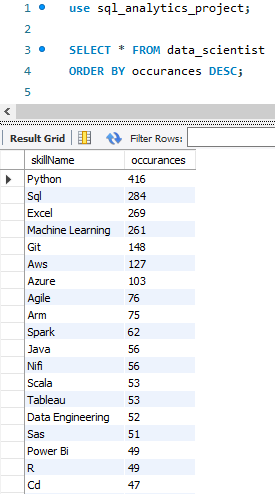

### Data visualization
We're getting data from a MySQL database. When we have just collected the data, it might not make sense to do this. But in case we have more data in the future, using the database will give us a more results.

In [58]:
#Liblary for ploting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
sns.set_style('dark')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [61]:
#get required skills for data scientist field from database
data_from_mysql = pd.read_sql_query("SELECT * FROM data_scientist",connection).sort_values("occurances",ascending=False)

C:\Users\User\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Text(0, 0.5, 'Occurances in job posts')

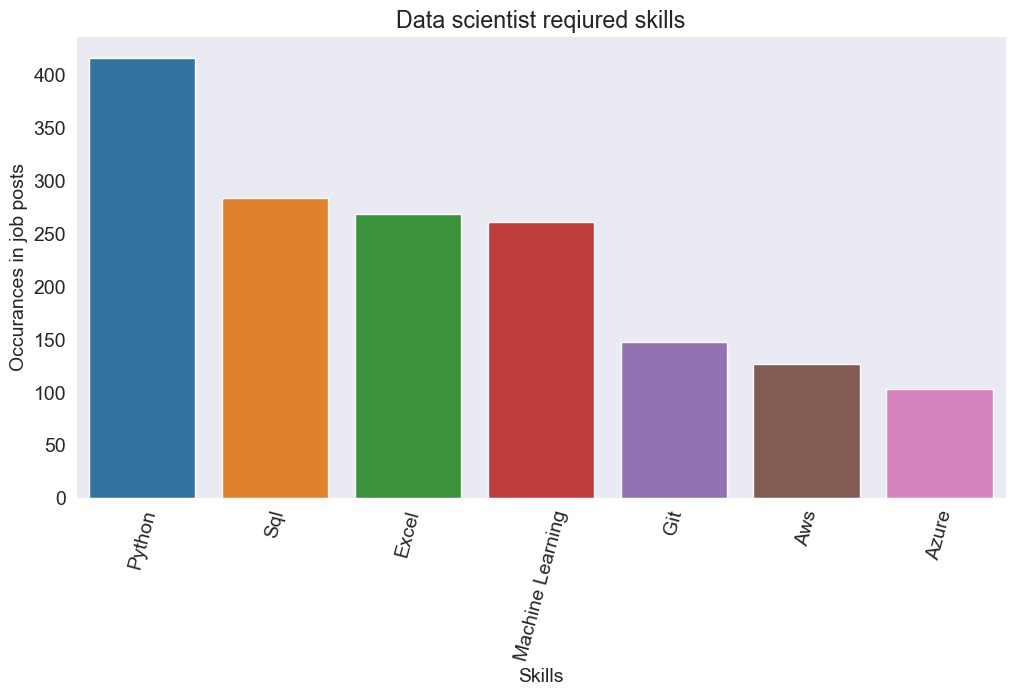

In [70]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title("Data scientist reqiured skills")
sns.barplot(x=data_from_mysql['skillName'].head(7), y=data_from_mysql['occurances'].head(7))
plt.xlabel("Skills")
plt.ylabel("Occurances in job posts")

In [71]:
connection.commit()

In [73]:
cursor.close()
connection.close()

Thanks for reading